In [ ]:
#all_slow

In [ ]:
#default_exp isola2017image

# Image-to-Image Translation with Conditional Adversarial Networks

Isola, P., Zhu, J. Y., Zhou, T., & Efros, A. A. (2017). Image-to-image translation with conditional adversarial networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1125-1134).

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export

from fastai.data.external import untar_data
from fastai.data.transforms import get_image_files
from fastai.data import *
from fastai.basics import *
from fastai.vision.data import *
from fastai.vision.core import *
from fastcore.all import *
from fastai.vision.augment import *
from fastai.vision.gan import *
from fastpapers.core import *

## The Data

We are going to use the CMP Facade Database [1], which is a set of images of building facades and with labels indicating different architecural objects, like window, balcony, door, etc. You can read more on details on its [web page](http://cmp.felk.cvut.cz/~tylecr1/facade/).

Let's use the untar_data function to download the dataset.There are two files, and we'll use both. We leave `cmp_b0068` and `cmp_b0331` out of the training set because the authors used those ones as examples in the paper. We are going to do the same.

In [ ]:
path_base = untar_data(URLs.FACADES_BASE)
path_extended = untar_data(URLs.FACADES_EXTENDED)
get_facade_files = partial(get_image_files, folders=['base', 'extended'])

def get_tuple_files(path):
    files = get_facade_files(path)
    avoid = ['cmp_b0068', 'cmp_b0331']
    g_files = groupby(files, lambda x: x.stem).values()
    return [sorted(v)[::-1] for v in g_files if v[0].name.split('.')[0] not in avoid]

def get_test_files(path):
    files = get_facade_files(path)
    avoid = ['cmp_b0068', 'cmp_b0331']
    g_files = groupby(files, lambda x: x.stem).values()
    return [sorted(v)[::-1] for v in g_files if v[0].name.split('.')[0] in avoid]
    

<AxesSubplot:>

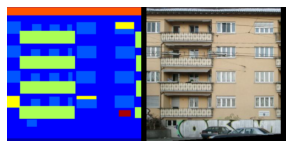

In [ ]:
files = get_tuple_files(path_base.parent)
ToTensor()(Resize(256)(ImageNTuple.create(files[0]))).show()

In [ ]:
im_size = 256
facades = DataBlock(
                    blocks=(ImageBlock, ImageTupleBlock),
                    get_items=get_tuple_files,
                    get_x=itemgetter(0),
                    splitter=RandomSplitter(seed=12,valid_pct=0.338),
                    item_tfms=Resize(2*im_size, ResizeMethod.Squish),
                    batch_tfms=[Normalize.from_stats(0.5*torch.ones(3), 0.5*torch.ones(3)), 
                                *aug_transforms(size=im_size,mult=0.1, max_lighting=0, p_lighting=0)],
                    )

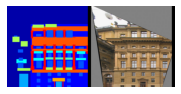

In [ ]:
dls = facades.dataloaders(path_base.parent, bs=1)
dls.show_batch()

## The loss

In [ ]:
#export
def gen_bce_l1_loss(fake_pred, output, target, l1_weight=100):
    l1_loss = nn.L1Loss()(output[-1],target[-1])
    ones = fake_pred.new_ones(*fake_pred.shape)
    bce_loss = nn.BCEWithLogitsLoss()(fake_pred, ones)
    return bce_loss + l1_weight*l1_loss

In [ ]:
#export
def crit_bce_loss(real_pred, fake_pred):
    ones  = real_pred.new_ones(*real_pred.shape)
    zeros = fake_pred.new_zeros(*fake_pred.shape)
    loss_neg = nn.BCEWithLogitsLoss()(fake_pred, zeros)
    loss_pos = nn.BCEWithLogitsLoss()(real_pred, ones)
    return (loss_neg+ loss_pos)/2

## The critic and the generator

In [ ]:
gen_base = basic_critic(64, n_channels=3, n_features=64, norm_type=NormType.BatchZero)
gen_base = nn.Sequential(*list(gen_base.children())[:-2])
generator = ConditionalGenerator(gen_base,3, (256, 256), 
                                 norm_type=NormType.BatchZero, 
                                 y_range=(-1,1),
                                 act_cls=partial(nn.LeakyReLU, negative_slope=0.2, inplace=True)
                                 )

In [ ]:
critic = SiameseCritic(basic_critic(64, n_channels=6, n_features=64,norm_type=NormType.BatchZero,
                                    act_cls=partial(nn.LeakyReLU, negative_slope=0.2, inplace=True)
                                   )
                      )

## Learning

In [ ]:
learn = GANLearner(dls,
                   generator,
                   critic,
                   gen_bce_l1_loss,
                   crit_bce_loss,
                   switcher=FixedGANSwitcher(n_crit=1, n_gen=1),
                   metrics=[l1],
                   opt_func = Adam,
                  )
learn.recorder.train_metrics=True
learn.recorder.valid_metrics=True

epoch,train_loss,train_l1,train_gen_loss,train_crit_loss,valid_loss,valid_l1,valid_gen_loss,valid_crit_loss,time
0,19.505747,0.391215,40.010044,0.485412,37.208263,0.365202,37.208263,1.621854,00:26
1,18.096821,0.358235,36.604607,0.189625,36.180019,0.350066,36.180019,0.034912,00:24
2,17.077171,0.352219,35.899052,0.102946,34.970211,0.347452,34.970211,0.006056,00:24
3,17.972046,0.340402,34.426746,0.050703,35.932922,0.345944,35.932922,0.016845,00:24
4,16.871004,0.350911,35.335793,0.049503,34.239113,0.342285,34.239113,0.000094,00:24
5,17.332048,0.345402,35.588531,0.086485,34.746815,0.342881,34.746815,0.000082,00:24
6,17.248844,0.341959,34.914200,0.038517,34.270981,0.342213,34.270981,0.000021,00:24
7,18.220549,0.348114,36.087643,0.166733,34.477711,0.341640,34.477711,0.000022,00:24
8,17.745466,0.343806,34.981602,0.055735,38.483974,0.344003,38.483974,0.001058,00:24
9,17.293514,0.348943,35.228939,0.071262,34.251968,0.342145,34.251968,0.000027,00:24


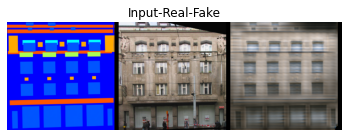

In [ ]:
epochs = 200
learn.fit(epochs, lr_max=0.0002, wd=0.5)
learn.show_results(max_n=1, ds_idx=0)

## Predicting

In [ ]:
@patch
def predict(self:GANLearner, item, rm_type_tfms=None, with_input=False):
    dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
    inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
    i = getattr(self.dls, 'n_inp', -1)
    inp = (inp,) if i==1 else tuplify(inp)
    n_out = len(self.dls.tls) - i
    dec_preds = (dec_preds,) if n_out==1 else tuplify(dec_preds)
    dec = self.dls.decode_batch(inp + dec_preds)[0]
    dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
    res = dec_targ,dec_preds[0],preds[0]
    if with_input: res = (dec_inp,) + res
    return res

<AxesSubplot:>

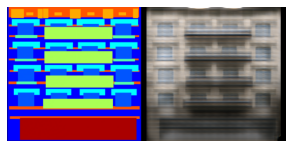

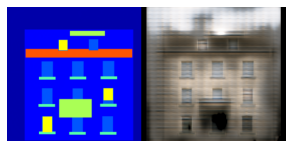

In [ ]:
test_files = get_test_files(path_base.parent)
ImageNTuple(learn.predict(test_files[0][0])[0]).show()
ImageNTuple(learn.predict(test_files[1][0])[0]).show()

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_isola2017image.ipynb.
Converted 02_heusel2017gans.ipynb.
Converted index.ipynb.
